<a href="https://colab.research.google.com/github/alorthius/LA-compendium/blob/master/labs/lab_2/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 &mdash; Fourier transform

## Submission rules
1. Submit this task as a link to Google Colab (https://colab.research.google.com/notebooks/intro.ipynb#). Make sure you made a copy of this notebook.

2. Form teams of 2-3 people and make only one submission per team. Mention all teammates in the name of the notebook and in the cms task description.

4. At the top of your notebook, provide a work-breakdown structure estimating efforts of each team member.

5. This lab requires some visualization from you; make them according to best practices (axes labels, title, proper size/scale etc). 

6. This lab is worth 4 points: 3 are given for the proper tasks solution and 1 for visuals and explanations. Explanations should give details on each step that you performed (e.g. how the data was transformed, what you used and why.)

7. Failure to comply with the submission rules can be a reason of up to 1 point deduction.

## Team & work breakdown:
1. Anna-Alina Bondarets - Tasks 1, 2 and all previous
2. Mykhailo-Taras Sobko - Tasks 3, 4
3. Mykhailo Bondarenko  - Tasks 5, 6

Tasks = tasks from `Analyzing Ukrainian anthem` section

## Introduction
Recently, you have learned about Fourier transform, i.e., an operator that maps functions depending on space (resp. time) variables into functions depending on spatial (resp. temporal) frequency, which is widely used in spectroscopy and signal processing.  

One of the motivations to use Fourier transform comes from the study of Fourier series. In our particular case, you will transform sound (a continuous wave that is a mixture of multiple frequencies) into an arrray of pure frequencies that can be analyzed, with the help of Discrete Fourier transform. The ultimate goal is to decompose a melody into a sequence of pitches and then to notes (without any help of a trained musician's ear &mdash; that would be cheating!). 

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import ifft, fft, fftfreq, fftshift
from IPython.display import Audio
# new imports
import soundfile as sf
import librosa.display
from scipy.signal import butter, lfilter, freqz

%matplotlib inline

## Sinusoids

Let's first consider a simple example. Decompose series sin3 that is a sum of 2 sinusoids using the Fast Fourier transform from scipy library. FFT is simply a computationally efficient implementation of a discrete Fourier transform. What is the frequency of sin1 and sin2 signals?

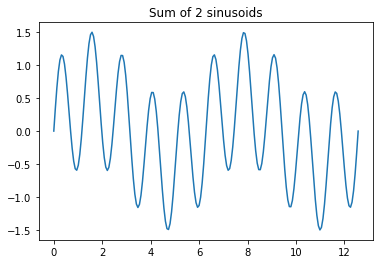

In [ ]:
x = np.linspace(0, 4*np.pi, 200)
sin1 = 0.5 * np.sin(x)
sin2 = np.sin(5*x)
sin3 = sin1 + sin2
plt.plot(x, sin3)
plt.title('Sum of 2 sinusoids')
plt.show()


Apply FFT to sin3 series to obtain frequency decomposition and plot the results.

Text(0.5, 1.0, 'Frequency decomposition')

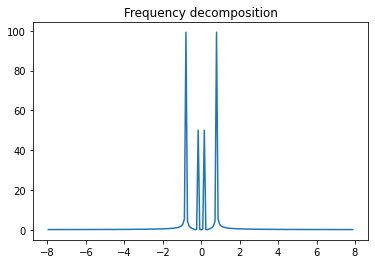

In [ ]:
# Plot Frequency-domain plot here
N = 200  # number of signal points
T = 4 * np.pi / N

yf = abs(fft(sin3))
xf = fftfreq(N, T)
plt.plot(fftshift(xf), fftshift(yf))
plt.title('Frequency decomposition')

Make sure that you got 2 spikes corresponding to the frequencies that we assigned to the sinusoids earlier. Explain how the tranformation is conducted and why can we obtain 2 perfectly separated frequencies from a mixed signal. 



We achieved two perfectly separated frequencies because the Fast Fourier transform returns a **symmetrically mirrored** result in case of plotting the absolute values of a real-valued function. Our $sin3$ function is real-valued, so FFT returns mirrored results for the negative frequencies. 

FFT returns both real and imaginary values as a decomposition, and magnitude of each corresponding frequency can be calculated as a norm of the returned vector:
$$
magnitude_i = \sqrt{real_i^2 + imag_i^2} = abs(\vec{yf_i})
$$

Text(0.5, 1.0, 'Imaginary part')

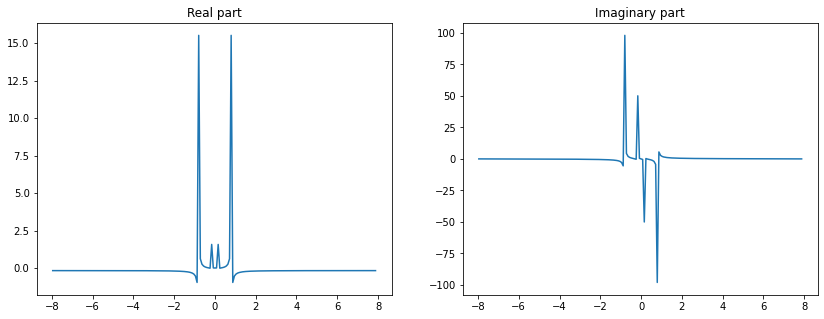

In [ ]:
yf_real = np.real(fft(sin3))
yf_imag = np.imag(fft(sin3))

_, (real, imag) = plt.subplots(1, 2, figsize=(14, 5))

real.plot(fftshift(xf), fftshift(yf_real))
real.set_title("Real part")

imag.plot(fftshift(xf), fftshift(yf_imag))
imag.set_title("Imaginary part")

As we can see, the real part of FFT is mirrored as well, yet the half of the complex part of the FFT result is a complex conjugate of other complex half, so the absolute value will be mirrored in case of a real-values funtion.

## Working with example audio

Now, let's work with a more complex wave&mdash;sound. Any sound (audio signal) can be characterized by the following three quantities: Pitch, Quality, and Loudness.

Loudness is a physiological sensation that depends mainly on sound wave pressure (amplitude). 

The lowest note in a chord is called fundamental. It is heard predominantly due to larger intensity. Quality is determined by overtones or harmonics that add to the sound of a fundamental note.

Pitch is the frequency of a sound as perceived by human ear. A high frequency gives rise to a high pitch note and a low frequency produces a low pitch note. A pure tone is the sound of only one frequency, such as that given by a tuning fork or electronic signal generator. Naturally, music does not consist of pure tones. Depending on an instrument, technique and many other factors, sound will decay at different rates and one tone will mix with the other ones.

Thus, transcribing audio files into standard notation for music is a non-trivial task. We will focus on recognizing pitches and matching them to notes. 

### Load and explore

In [ ]:
# Load first sound from library examples
# Monophonic trumpet recording
trumpet_path = librosa.example('trumpet')
Audio(trumpet_path)

In [ ]:
trumpet_sample, trumpet_sampling_rate = librosa.load(trumpet_path)

What is a sampling rate? What does sampling rate imply about the audio? Is it sufficient for our task (according to https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)?


**Sampling rate** or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal.

The **Nyquist–Shannon sampling theorem** (Nyquist principle) states that perfect reconstruction of a signal is possible when the sampling frequency is *greater than twice the maximum* frequency of the signal being sampled. For example, if an audio signal has an upper limit of 20,000 Hz (the approximate upper limit of human hearing), a sampling frequency greater than 40,000 Hz (40 kHz) will avoid aliasing and allow theoretically perfect reconstruction.

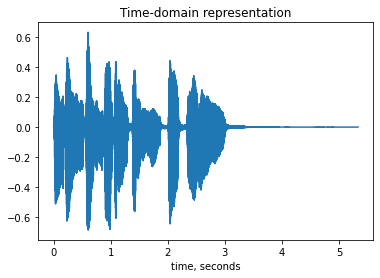

In [ ]:
# Initial visualization
time = np.array(range(trumpet_sample.shape[0])) / trumpet_sampling_rate
plt.plot(time, trumpet_sample)
plt.title('Time-domain representation')
plt.xlabel('time, seconds')
plt.show()

This visualization is called the time-domain representation of a given signal. This shows us the loudness (amplitude) of sound wave changing with time. Here amplitude = 0 represents silence. These amplitudes are not very informative, as they only talk about the loudness of audio recording. To better understand the audio signal, it is necessary to transform it into the frequency-domain. The frequency-domain representation of a signal tells us what different frequencies are present in the signal.   

Decompose the trumpet samples using fft and plot the results. Observe that the frequency pattern corresponds to the pitch changes.

Text(0, 0.5, 'Magnitude')

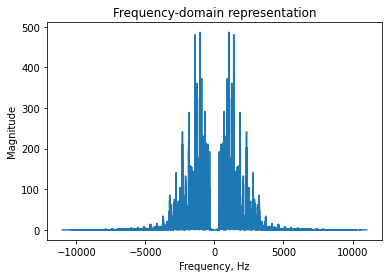

In [ ]:
# FFT for trumpet
yf = abs(fft(trumpet_sample))
xf = fftfreq(trumpet_sample.size, time[1] - time[0])
plt.plot(fftshift(xf), fftshift(yf))
plt.title('Frequency-domain representation')
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')

The transform also produces a mirror copy of the spikes, which correspond to the signal's negative frequencies.

## Analyzing Ukrainian anthem

For the next task you need to take the recording of Ukrainian anthem attached on cms. Your creativity is not limited here so any better ways to filter noise, compelling visuals, more advanced algorithms on top of FFT or spectrogram, and explanations will be rewarded.     


1.   Load the recording, replay it, and plot in the time domain. To get a better view of how the notes change throughtout a shorter time, choose a sample of the audio up to 5 seconds and plot it in the time domain. From here on out you will be working with this smaller 5-second sample.


In [ ]:
path = "ukrainian_anthem_piano.mp3"
Audio(path)

In [ ]:
# Loading sound and trim to 5 sec
samples, sampling_rate = librosa.load(path, duration=5.0)
# Save and play trimmed version
sf.write("5sec.wav", samples, sampling_rate)
Audio("5sec.wav")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


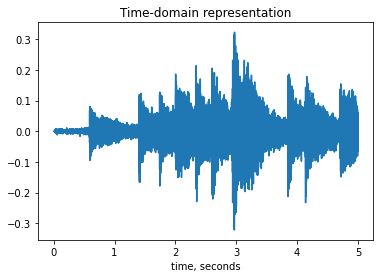

In [ ]:
time = np.array(range(samples.shape[0])) / sampling_rate
plt.plot(time, samples)
plt.title('Time-domain representation')
plt.xlabel('time, seconds')
plt.show()

2.   Build a spectrogram of the sample. Explain what domain the spectrogram shows us and how can it be useful.


A **spectrogram** is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.
We can display a spectrogram using `librosa.display.specshow`.

Text(0.5, 1.0, 'Logarithmic spectogram')

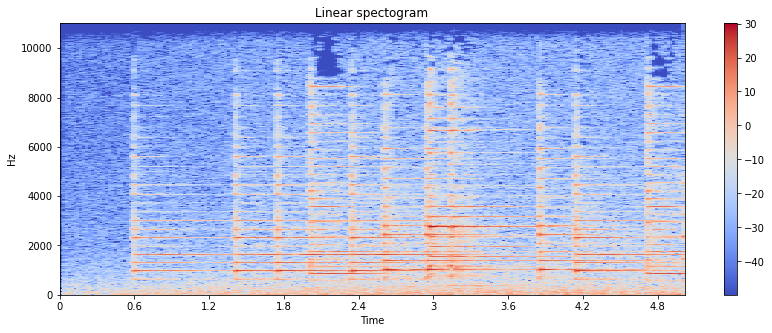

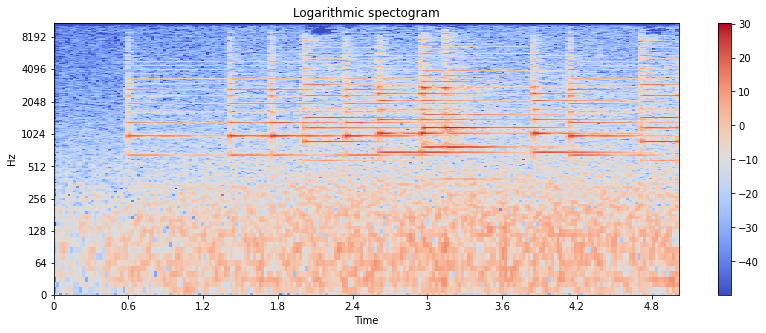

In [ ]:
dbX = librosa.amplitude_to_db( abs(librosa.stft(samples)) )

plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Linear spectogram")

plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Logarithmic spectogram")

As we can see, the most *red*-ish colors depicts the most intense frequencies ranging from (approximately) $512$ to $3000$ Hz starting from approximately $1.5$ second till the end. On the logarithmic spectrogram we see that the noise (low frequencies) is also pretty loud during all the recording.

**Chroma representations** don’t have a fixed frequency axis, and instead aggregate information across all frequencies corresponding to a given pitch class. `specshow` can plot these too:

Text(0.5, 1.0, 'Chroma representation')

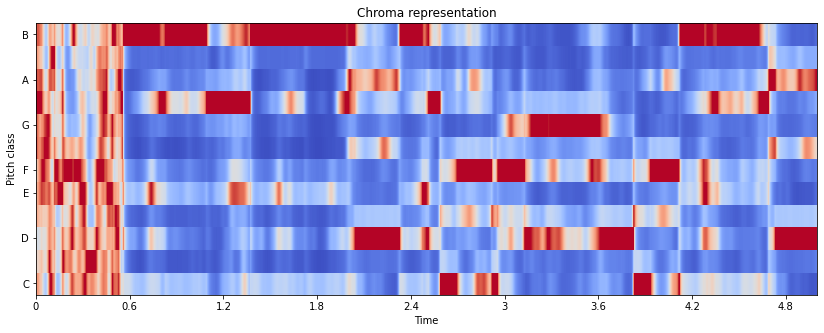

In [ ]:
chromagram = librosa.feature.chroma_stft(samples, sr=sampling_rate, hop_length=12)
plt.figure(figsize=(14, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=12, cmap='coolwarm')
plt.title("Chroma representation")

3.   Transform signal to the frequency domain with FFT and study the distribution of pitches (frequencies).
Observe that the melody contains only a couple of distict sounds, but there is a lot more spikes in the frequency domain.

Text(0, 0.5, 'Magnitude')

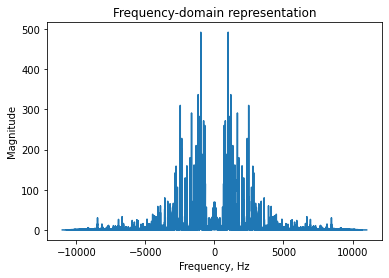

In [ ]:
yf = abs(fft(samples))
xf = fftfreq(samples.size, time[1] - time[0])
plt.plot(fftshift(xf), fftshift(yf))
plt.title('Frequency-domain representation')
plt.xlabel('Frequency, Hz')
plt.ylabel('Magnitude')

4.    Find typical piano notes frequencies table and propose a way to filter noise. (Hint: minimum pitch for a piano is 27.5 Herz)  

Most pianos have keys with frequencies between 27.5 Hz and 4186.009 Hz, so we should apply a band-pass filter here to cut off all the noise above and below the given range.

One of the most popular filters for this is a butterworth filter, since it is maximally flat (i.e. has no ripples) in the passband and rolls off towards zero in the stopband

The Nyquist rate or frequency is the minimum rate at which a finite bandwidth signal needs to be sampled to retain all of the information. If a time series is sampled at regular time intervals $dt$, then the Nyquist rate is just $\frac{1}{2dt}$).

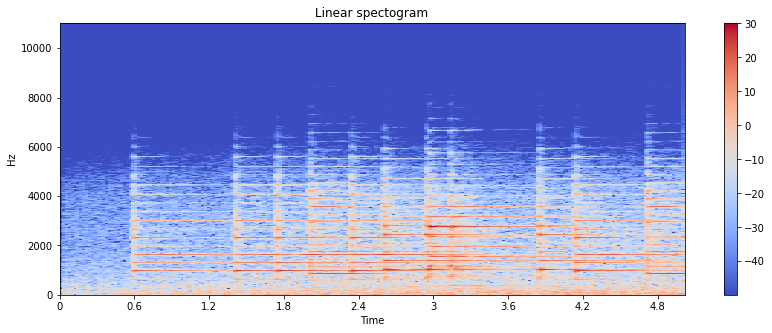

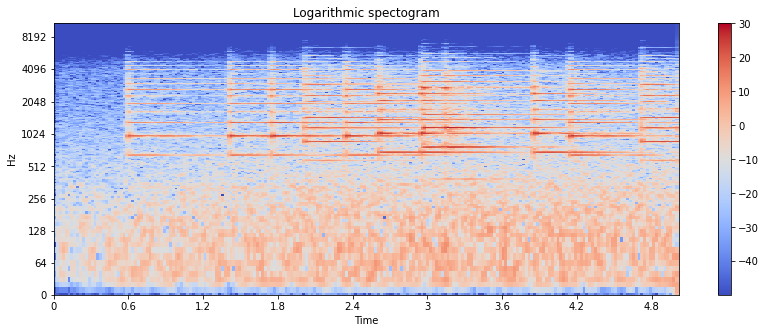

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Desired cutoff frequencies (in Hz). Slightly broader than the ideally
# calculated frequency since in real life the signal frequency may fluctuate
lowcut = 27.0
highcut = 4187.0

filtered_samples = butter_bandpass_filter(samples, lowcut, highcut,
                                          sampling_rate)

dbX = librosa.amplitude_to_db(abs(librosa.stft(filtered_samples)))
plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Linear spectogram")

plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Logarithmic spectogram")

sf.write("filtered_5sec.wav", filtered_samples, sampling_rate)
Audio("filtered_5sec.wav")

As we can clearly see comparing the old and the new logarithmic spectrograms, the frequencies below ~$27.5 Hz$ are now of cold color, representing the less intense noise. On the linear spectograms we also see the obvious reduction of the high frequencies above ~$4000 Hz$. 

5. Apply averaging to initial signal. Averaging is a procedure that reduces number of samples by taking mean of each n of our samples. Experiment with n and determine whichever will work best to both reduce the noise and not loose any information. You can propose other ways to efficiently reduce the noise in the signal.

1) Proposed averaging method divides the sample rate by n, which keeps only the frequencies that are below the new sample rate divided by 2. This means that we can remove higher frequencies. This method is implemented in the average_over() function.\
\
2) Next, I tried to implement rolling average. It does the same thing as the previous method, but keeps the sample rate. The first element of the resulting array is the mean of the first n elements, the second is the mean of [1:n+1], the third of [2:n+2], and so on. This method also cuts high frequencies, but less efficiently than the first method (some of them are being kept).\
\
3) In the third method, noticing that the 1st method can keep only the lower frequencies (which are noise in this case), I ran the first method with a high n setting, and extrapolated it to substract it from the original signal. As a result, I got rid of the low-frequecy noise.

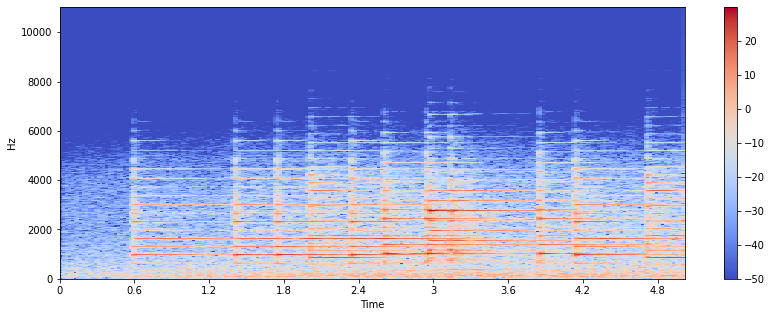

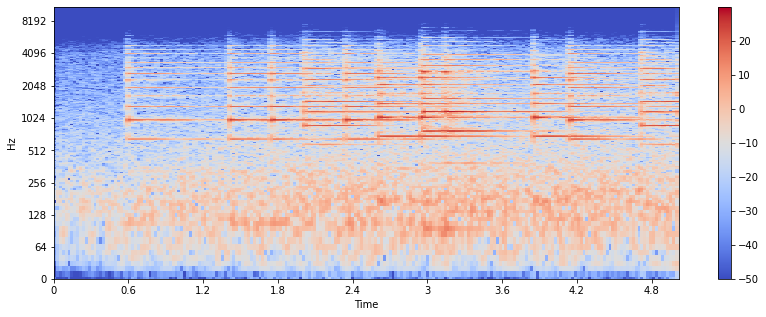

In [ ]:
from scipy import interpolate

# first method
def average_over(samples, sampling_rate, n=2):
    result = np.sum(
        [samples[i::n][:(samples.shape[0]//n)] for i in range(n)], axis=0
      ) / n
    return result, sampling_rate // n
  
# second method; rolling average
def rolling_average_over(samples, sampling_rate, n=8):
    result = np.sum([
        samples[i:samples.shape[0]-n+i+1] for i in range(n)
    ], axis=0) / n
    return result, sampling_rate

# third method; remove lower frequencies
def remove_lower(samples, sampling_rate, hz=440):
    n = sampling_rate // hz
    # obtain lower frequencies
    averaged_samples_x = np.arange(n, len(samples)+1, n)
    averaged_samples, _ = average_over(samples, sampling_rate, n)
    # interpolate using CubicSpline
    averaged_samples_ext_x = np.arange(n, len(samples) - len(samples)%n)
    samples = samples[n:len(samples) - len(samples)%n]
    averaged_samples_ext = interpolate.CubicSpline(
        averaged_samples_x, averaged_samples
    )(
        averaged_samples_ext_x
    )
    # substract and get the result
    return samples - averaged_samples_ext, sampling_rate

averaged_samples, sampling_rate_new = remove_lower(filtered_samples, sampling_rate)

dbX = librosa.amplitude_to_db(abs(librosa.stft(averaged_samples)))
plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate_new, x_axis='time', y_axis='hz')
plt.colorbar()

plt.figure(figsize=(14, 5))
librosa.display.specshow(dbX, sr=sampling_rate_new, x_axis='time', y_axis='log')
plt.colorbar()

sf.write("averaged_5sec.wav", averaged_samples, sampling_rate_new)
Audio("averaged_5sec.wav")

It can be seen that the third method indeed reduсes the low-frequency noise, but of course it's not as efficient as the previous method.

6. Match fundamental pitches you discovered to the standard notes frequencies and display them in a table like the one outlined below.

|Detected frequency(Hz) | Assigned frequency(Hz) | Output note|   
|:---------------------:|:----------------------:|:----------:|
|393.2 |391.9| G4  

The frequency of a note, given its number, is given by the formula:\
$f(n) = (\sqrt[\leftroot{-2}\uproot{2}12]{2})^{n-49}*440Hz$\
Using that, we can construct an inverse function to get the closest note from its frequency\
$n(x) = {\lfloor \log_2(\frac{x}{440}) * 12 + 49 \rceil}$\
For convenience, we can use that rounded value to collect detected frequencies close to some specific note, and then from those select only the closest one to be the 'detected' one displayed in the table.\
To consider only those frequencies which are loud enough, we use the $threshold$ intensity parameter, which in this case is equal to 150.

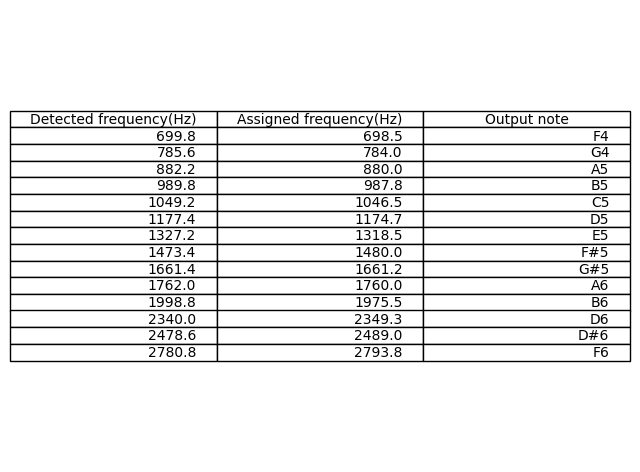

In [ ]:
yf = fft(samples)
xf = fftfreq(samples.size, time[1] - time[0])
yf_p = abs(yf[:yf.shape[0]//2])
xf_p = xf[:xf.shape[0]//2]

threshold = 150
notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
notes_map = {}
for x in xf_p[yf_p > threshold]:
    note_num = round(np.log2(x/440) * 12 + 49)
    note_str = notes[(note_num - 1) % 12]
    det_freq = pow(2, (note_num - 49)/12) * 440
    if note_num in notes_map:
        if abs(
               notes_map[note_num][2] - notes_map[note_num][1]
           ) < abs(det_freq - x):
           continue
    notes_map[note_num] = (
        note_str + str((note_num - 1) // 12),
        x, det_freq
    )

notes_table = [
    (round(c, 1), round(d, 1), b)
    for a, (b, c, d) in notes_map.items()
]

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(
    notes_table, colLabels = [
        "Detected frequency(Hz)", "Assigned frequency(Hz)", "Output note"
    ], loc='center'
)

# try to keep only the selected frequencies and check the result
clear_samples = np.sum([
    butter_bandpass_filter(samples, pow(f, 0.995), pow(f,1.005), sampling_rate)
    for f, _, _ in notes_table
], axis=0)
sf.write("clear_5sec.wav", clear_samples, sampling_rate)
Audio("clear_5sec.wav")

## Summary

1. How can Fourier transform be used in signal processing?

The Fourier transform is a mathematical formula that relates a signal sampled in time or space to the same signal sampled in frequency. Thus, it can reveal importtant characteristics of signal, namely, its frequency components, which gives an opportunity to further analyze the discrete signal.

2. What are time and frequency domains and how can they be useful?

The time domain representation of a given signal shows us the loudness (amplitude) of sound wave changing with time. These amplitudes are not very informative, as they only talk about the loudness of audio recording.

The frequency domain representation of a signal tells us what different frequencies are present in the signal. A frequency-domain representation can also include information on the phase shift that must be applied to each sinusoid in order to be able to recombine the frequency components to recover the original time signal. 

A time-domain graph shows how a signal changes with time, whereas a frequency-domain graph shows how much of the signal lies within each given frequency band over a range of frequencies.

A given function or signal can be converted between the time and frequency domains using mathematical transformations.

3. What is averaging and what is its purpose?

Averaging is reducing the sample rate by taking the average over n consequent samples in the source signal and making it a sample in the output signal. Its purpose may be to remove the unneeded high frequencies using the Nyquist rate, or to compress the audio, since we'll have to store n times less samples.